In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from nbdev.showdoc import *

## Types

In [ ]:
import dataclasses
import enum
from enum import IntEnum
from typing import Generic, TypeVar, List, Union, Callable

from scipy.interpolate import interp1d
import numpy as np

Numeric = Union[float, np.ndarray]

## Converters

In [ ]:
def kn_to_m_per_s(v_kn: Numeric) -> Numeric:
    return v_kn * 0.5144


def m_per_s_to_kn(v_m_per_s: Numeric) -> Numeric:
    return v_m_per_s / 0.5144


## Interplation Function that Returns the information of whether the output is extrapolated

In [ ]:
class WarningType(IntEnum):
    UNKNOWN = -1
    EXTRAPOLATED_CALMWATER_POWER = enum.auto()
    EXTRAPOLATED_CALMWATER_SPEED = enum.auto()
    EXTRAPOLATED_SEAMARGIN = enum.auto()
    EXTRAPOLATED_PROPULSION_POWER = enum.auto()
    EXTRAPOLATED_PROPULSION_SPEED = enum.auto()
    EXTRAPOLATED_ACCELERATION = enum.auto()
    EXTRAPOLATED_COASTING = enum.auto()
    GYMIR_ERROR = enum.auto()
    MISSING_PATH = enum.auto()
    MISSING_PLACE = enum.auto()
    MISSING_HULL = enum.auto()
    WRONG_INPUT = enum.auto()


@dataclasses.dataclass
class WarningMessage:

    code: WarningType
    title: str
    description: str
    hint: str


T = TypeVar("T")
Numeric = Union[float, np.ndarray]


@dataclasses.dataclass
class InterpolatedValue:
    value: Numeric
    _is_extrapolated: bool

    def __init__(self, value: Numeric, *, is_extrapolated: bool):
        self.value = value
        self._is_extrapolated = is_extrapolated

    @property
    def cause(self) -> str:
        if self.is_extrapolated:
            return "value is outside of input data range."
        else:
            raise ValueError()

    @property
    def is_extrapolated(self) -> bool:
        return self._is_extrapolated


@dataclasses.dataclass
class Interpolated1DValue(InterpolatedValue):
    value: Numeric
    is_too_high: bool = False
    is_too_low: bool = False
    extrapolated_with_origo: bool = False  # Added y=x=0 to avoid extrapolation

    def __init__(
        self,
        value: Numeric,
        *,
        x: Numeric,
        x_min: float,
        x_max: float,
        extrapolated_with_origo: bool,
    ):
        self.value = value
        if np.any(x < x_min):
            self.is_too_low = True
            self.extrapolated_with_origo = extrapolated_with_origo
        elif np.any(x > x_max):
            self.is_too_high = True

    @property
    def is_extrapolated(self) -> bool:
        return self.is_too_low or self.is_too_low

    @property
    def cause(self) -> str:
        if self.is_too_high:
            return "value is higher than input data."
        elif self.extrapolated_with_origo:
            return (
                "value is below input data, but a (0,0) value is used to interpolate."
            )
        elif self.is_too_low:
            return "value is below input data."
        else:
            raise ValueError()


class Result(Generic[T]):
    def __init__(self, value: T, *warnings: WarningMessage) -> None:
        self.value: T = value
        self.warnings: List[WarningMessage] = list(warnings)

    def append_warning(self, *warning: WarningMessage) -> None:
        self.warnings += warning


def get_interpolation_1d_function(
    *,
    x: np.ndarray,
    y: np.ndarray,
    add_origo: bool,
    kind: Union[str, int] = "cubic",
) -> Callable[[float], Interpolated1DValue]:
    """Returns the interpolation 1d function
    add_origin: (0,0) is added as a value if add_origin is true and x[0] > 0
    """

    xmin = x.min()
    if add_origo and x[0] > 0:
        # prepend (0,0)
        x = np.insert(x, 0, 0.0)  # type: ignore[no-untyped-call]
        y = np.insert(y, 0, 0.0)  # type: ignore[no-untyped-call]

    f = interp1d(
        x=x,
        y=y,
        kind=kind,
        fill_value="extrapolate",
        bounds_error=False,
    )

    def interp(xi: float) -> Interpolated1DValue:
        v = f(xi)
        return Interpolated1DValue(
            v, x=xi, x_min=xmin, x_max=x[-1], extrapolated_with_origo=add_origo
        )

    return interp


def get_froude_number(speed_kn: Numeric, lpp_m: float) -> Numeric:
    """Returns the Froude number for a given speed and length

    @param speed_kn: speed in knots
    @param lpp_m: length in meters
    @return: Froude number
    """
    return kn_to_m_per_s(speed_kn) / np.sqrt(9.81 * lpp_m)


def get_speed_kn_from_froude_number(froude_number: Numeric, lpp_m: float) -> Numeric:
    """Returns the speed for a given Froude number and length

    @param froude_number: Froude number
    @param lpp_m: length in meters
    @return: speed in knots
    """
    return m_per_s_to_kn(froude_number * np.sqrt(9.81 * lpp_m))

In [ ]:
import nbdev; nbdev.nbdev_export()

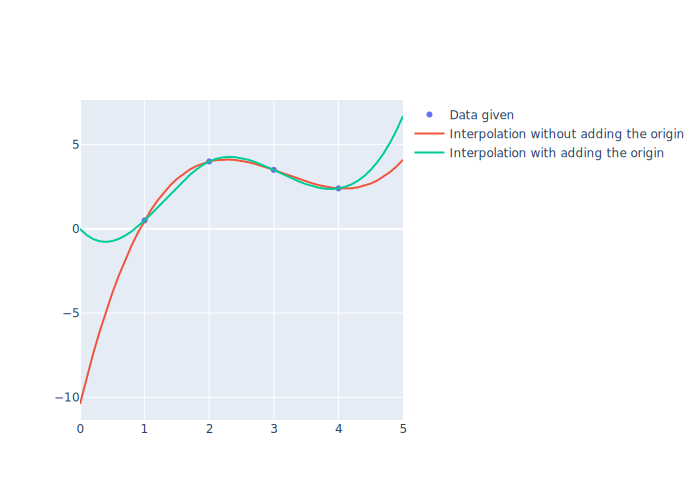

In [ ]:
# Testing interpolation function
from ship_model_lib.utility import get_interpolation_1d_function
from plotly.subplots import make_subplots
import plotly.graph_objects as go

interp_x_data = np.array([1, 2, 3, 4])
interp_y_data = np.array([0.5, 4, 3.5, 2.4])

interp_function_with_out_origo = get_interpolation_1d_function(x=interp_x_data, y=interp_y_data, add_origo=False)

assert interp_function_with_out_origo(0).value != 0, "The function should not be zero when origin was not added."
assert interp_function_with_out_origo(0).is_extrapolated, "The value is extrapolated, while the object says that it is not."

x_new = np.linspace(0, 5, 51)
y_new = interp_function_with_out_origo(x_new).value
fig = make_subplots()
fig.add_trace(go.Scatter(x=interp_x_data, y=interp_y_data, name="Data given", mode="markers"))
fig.add_trace(go.Scatter(x=x_new, y=y_new, name="Interpolation without adding the origin"))

interp_function_with_origo = get_interpolation_1d_function(x=interp_x_data, y=interp_y_data, add_origo=True)

assert interp_function_with_origo(0).value == 0, "The function should be zero when origin was added."
assert interp_function_with_origo(0).is_extrapolated, "The value is extrapolated, while the object says that it is not."

x_new = np.linspace(0, 5, 51)
y_new = interp_function_with_origo(x_new).value
fig.add_trace(go.Scatter(x=x_new, y=y_new, name="Interpolation with adding the origin"))
fig.show(renderer="png")

## Converters